### Переменные тональности

Word Category Proportions using word lists created by Loughran and Mcdonald (2011): 
   1. total word count, 
   2. proportion of positive, negative, uncertainty, limiting, litigious, strong modal and weak modal words, 
   3. overall tone of the text.

Readability ratios by Humpherys, Moffitt, Burns, Burgoon and Felix (2011) and Li (2008): 
   1. average sentence length, 
   2. complex word proportion, 
   3. Fog index equaling 0.4 * (Average Sentence Length + Complex Word Proportion)

|Abbrev.| Linguistic variable|
|-------|--------------------|
|Pos| frequency count of positive words/length of MD&A|
|Neg| frequency count of negative words/length of MD&A|
|Tone| (frequency count of positive words – frequency count of negative words) / (frequency count of positive words + frequency count of negative words)|
|Uncert| frequency count of uncertain words/length of MD&A|
|Constr| frequency count of constraining words/length of MD&A|
|Litig| frequency count of litigious words/length of MD&A|
|ModStrong| frequency count of modal strong words / length of MD&A|
|ModWeak| frequency count of modal weak words/length of MD&A|

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

## Загрузка словаря

In [2]:
LM_dictionary = pd.read_excel('LM_dict.xlsx', nrows=86531)
LM_dictionary

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [3]:
tonality_lexicon = LM_dictionary[["Word", "Positive", "Negative", "Uncertainty", 
                                  "Constraining", "Litigious", "Strong_Modal", 
                                  "Weak_Modal"]]
tonality_lexicon

,Word,Positive,Negative,Uncertainty,Constraining,Litigious,Strong_Modal,Weak_Modal
0,AARDVARK,0,0,0,0,0,0,0
1,AARDVARKS,0,0,0,0,0,0,0
2,ABACI,0,0,0,0,0,0,0
3,ABACK,0,0,0,0,0,0,0
4,ABACUS,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
86526,ZYGOTE,0,0,0,0,0,0,0
86527,ZYGOTES,0,0,0,0,0,0,0
86528,ZYGOTIC,0,0,0,0,0,0,0
86529,ZYMURGIES,0,0,0,0,0,0,0


### Преобразование текста

In [4]:
import nltk
import re
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [5]:
def word_preprocessing(word): 
    # приводим все к нижнему регистру
    word = word.lower()
    # лемматизация
    word = lemmatizer.lemmatize(word)
    return word

In [6]:
#создаем списки отдельно для негативных, позитивных, ограничивающих и неопределенных слов

def dictionary(df, column, new_list):
    for i in df[column]:
        j = word_preprocessing(str(i))
        new_list.add(str(j))
    return new_list

positive = tonality_lexicon.loc[tonality_lexicon['Positive'] != 0]
pos_list = set()

negative = tonality_lexicon.loc[tonality_lexicon['Negative'] != 0]
neg_list = set()

uncertainty = tonality_lexicon.loc[tonality_lexicon['Uncertainty'] != 0]
unc_list = set()

constraining = tonality_lexicon.loc[tonality_lexicon['Constraining'] != 0]
cons_list = set()

litigious = tonality_lexicon.loc[tonality_lexicon['Litigious'] != 0]
lit_list = set()

strong_modal = tonality_lexicon.loc[tonality_lexicon['Strong_Modal'] != 0]
modstrong_list = set()

weak_modal = tonality_lexicon.loc[tonality_lexicon['Weak_Modal'] != 0]
modweak_list = set()

dictionary(positive, 'Word', pos_list)
dictionary(negative, 'Word', neg_list)
dictionary(uncertainty, 'Word', unc_list)
dictionary(constraining, 'Word', cons_list)
dictionary(litigious, 'Word', lit_list)
dictionary(strong_modal, 'Word', modstrong_list)
dictionary(weak_modal, 'Word', modweak_list)

{'almost',
 'apparently',
 'appeared',
 'appearing',
 'appears',
 'conceivable',
 'could',
 'depend',
 'depended',
 'depending',
 'depends',
 'may',
 'maybe',
 'might',
 'nearly',
 'occasionally',
 'perhaps',
 'possible',
 'possibly',
 'seldom',
 'seldomly',
 'sometimes',
 'somewhat',
 'suggest',
 'suggests',
 'uncertain',
 'uncertainly'}

In [41]:
neg_list

{'contesting',
 'divestment',
 'inaccurately',
 'culpably',
 'misconduct',
 'seize',
 'counterclaim',
 'deprived',
 'noncompliant',
 'cautioned',
 'prolongation',
 'endangers',
 'coerces',
 'overstated',
 'tense',
 'excessively',
 'downsized',
 'criticize',
 'harming',
 'closure',
 'disqualify',
 'reassignment',
 'untimely',
 'deprives',
 'protested',
 'undercut',
 'untenable',
 'encumbered',
 'easing',
 'impounding',
 'fraudulence',
 'unfulfilled',
 'disproportionately',
 'erring',
 'objecting',
 'impairment',
 'fatally',
 'ignores',
 'monopolize',
 'diminished',
 'underperforming',
 'correction',
 'unfortunate',
 'inactivate',
 'tolerate',
 'precipitous',
 'abdicates',
 'circumvents',
 'inadvertently',
 'overcomes',
 'retaliated',
 'corrects',
 'canceled',
 'concealing',
 'confiscated',
 'deceptive',
 'unknowingly',
 'unsalable',
 'dishonorably',
 'exaggerates',
 'uncovering',
 'stressful',
 'unresolved',
 'disagreement',
 'penalize',
 'stopping',
 'complicating',
 'adversary',
 'imp

## Загрузка данных

In [7]:
df = pd.read_excel('База данных.xlsx', sheet_name = 'Лист3', nrows=393)
df.sample(n=10)

,название,year,text,fraud
204,роснефть,2016,2016 will go down in the history of Rosneft as...,1
61,евраз,2020,Despite the unpredictable challenges of the CO...,1
162,огк-2,2016,"In 2016, Gazprom continued the dynamic develop...",0
329,суэк,2016,Leading the way in social development We’re co...,0
254,россети центр и приволжье,2020,The restrictive measures associated with the C...,1
163,окей,2020,2020 has undoubtfully brought unprecedented ch...,0
181,полиметалл,2017,"In 2018, Polymetal celebrates its 20th anniver...",0
352,уралкалий,2015,"Аs you know, Uralkali is one of the leaders of...",0
9,аэрофлот,2019,2019 was the first full year in which Aeroflot...,1
147,новатэк,2016,TWO THOUSAND AND SIXTEEN was another year of s...,1


In [8]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Загружаем стандартный список стоп-слов
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')

In [9]:
# Добавляем в список стоп-слов названия стран
import pycountry 

for country in pycountry.countries:
    name = country.name.split(' ')
    for i in name:
        j = re.sub('[^A-Za-z]+', '', i)
        j = j.lower()
        if j not in stopwords:
            stopwords.append(j)

In [10]:
# Добавляем в список стоп-слов названия месяцев
import calendar

for month in list(calendar.month_name)[1:]:
    stopwords.append((month.lower()))

In [11]:
# Добавляем в список стоп-слов названия компаний и др. слова, 
# встречающиеся в текстах отчетов, которые можно отнести к стоп-словам

companies = ['group', 'pjsc', 'acron', 'sistema', 'aeroflot', 'beluga', 'gazprom', 'etalon',
             'lsr', 'cherkizovo', 'detsky', 'mir', 'evraz', 'lukoil', 'magnit', 'mvideo', 
             'eldorado', 'megafon', 'metalloinvest', 'mmk', 'mosenergo', 'mts', 'nlmk', 
             'novatek', 'nornickel', 'okey', 'polymetal', 'petropavlovsk', 'polyus', 
             'railways', 'rosatom', 'rosneft', 'rosseti', 'moesk', 'idgc', 'northern', 
             'caucasus', 'kuban', 'northwest', 'urals', 'center', 'volga', 'region', 
             'south', 'rostelecom', 'rostec', 'rusagro', 'rushydro', 'russneft', 'severstal', 
             'segezha', 'sovcomflot', 'suek', 'tatneft', 'tele', 'tmk', 'uralkali', 'phosagro', 
             'unipro', 'uniper', 'globaltrans', 'retail', 'x', 'synergy', 'oleniy', 'ruchey', 
             'kerch', 'safmar', 'russian', 'chinese', 'moscow', 'siberia', 'odintsovo', 
             'uk', 'us', 'usa', 'npp', 'due', 'two', 'russia', 'company', 'vorkutaugol',
            'c', 'second', 'harjavalta', 'dixy', 'fi', 'fy', 'ural', 'sverdlovsk', 'kubanenergo',
            'kv', 'rusal', 'nizhny', 'eu', 'hva', 'komi', 'one', 'kaluga', 'year', 'meat', 
             'passenger', 'oblast', 'nancial', 'pl', 'naletu', 'lenta', 'bristol', 'id', 
             'kirovsky', 'yandex', 'lavka', 'nd', 'aa', 'aaa', 'aac', 'ab', 'abc', 'ad', 
             'ag', 'ai', 'al', 'ano', 'ant', 'anton', 'antonina', 'antonios', 'antoniou', 
             'antonyan', 'ar', 'az', 'b', 'ba', 'baa', 'bb', 'bbb', 'bdd', 'bboe', 'bi', 'bf']

for company in companies:
    stopwords.append(company)

In [12]:
def data_preprocessing(text): 
    # очистка данных
    text = re.sub(re.compile('<.*?>'), '', text) 
    text =  re.sub('[^A-Za-z]+', ' ', text) 
    
    # приводим все к нижнему регистру
    text = text.lower()
    # приводим слова к токенам
    tokens = nltk.word_tokenize(text)
    # удаляем стоп-слова
    text = [word for word in tokens if word not in stopwords]
    # лемматизация
    text = [lemmatizer.lemmatize(word) for word in text]
    # соединяем слова обратно в текст
    text = ' '.join(text)
    
    return text

In [13]:
df['text']

0      The past year was a true ordeal for the whole ...
1      The global mineral fertiliser market was preca...
2      In 2018, Acron Group continued to pursue its u...
3      The year 2017 saw positive trends on the miner...
4      The last year was one of the decade’s most cha...
                             ...                        
381    It is my pleasure to report that X5 Retail Gro...
382    As I look back at 2017 and our outlook at the ...
383    It has been just over one year since I took ov...
384    X5 aims to create value for all of its stakeho...
385    Your Company performed well in 2014, deliverin...
Name: text, Length: 386, dtype: object

In [14]:
df['preprocessed_text'] = df['text'].apply(lambda text: data_preprocessing(text))
df.head()

,название,year,text,fraud,preprocessed_text
0,акрон,2020,The past year was a true ordeal for the whole ...,0,past true ordeal whole world covid pandemic br...
1,акрон,2019,The global mineral fertiliser market was preca...,0,global mineral fertiliser market precarious pr...
2,акрон,2018,"In 2018, Acron Group continued to pursue its u...",0,continued pursue updated development strategy ...
3,акрон,2017,The year 2017 saw positive trends on the miner...,0,saw positive trend mineral fertiliser market f...
4,акрон,2016,The last year was one of the decade’s most cha...,0,last decade challenging year global mineral fe...


### Создание переменных тональности

In [15]:
def positive_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    pos = len([e for e in sent if e in pos_list])
    return pos / total

In [16]:
def negative_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    neg = len([e for e in sent if e in neg_list])
    return neg / total

In [17]:
def tone(sent):
    pos = len([e for e in sent if e in pos_list])
    neg = len([e for e in sent if e in neg_list])
    return (pos - neg) / (pos + neg)

In [18]:
def uncertainty_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    unc = len([e for e in sent if e in unc_list])
    return unc / total

In [19]:
def constraining_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    cons = len([e for e in sent if e in cons_list])
    return cons / total

In [20]:
def litiguous_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    lit = len([e for e in sent if e in lit_list])
    return lit / total

In [21]:
def modstrong_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    modstr = len([e for e in sent if e in modstrong_list])
    return modstr / total

In [22]:
def modweak_proportion(sent):
    sent = [e.lower() for e in sent]
    total = len(sent)
    modwk = len([e for e in sent if e in modweak_list])
    return modwk / total

In [23]:
def proportion(review, function):
    proportion = []
    sents = sent_tokenize(review)
    for sent in sents:
        wds = word_tokenize(sent)
        sent_scores = function(wds)
        proportion.append(sent_scores)
    return sum(proportion) / len(proportion)

### Создание переменных сложности текста для понимания и прочтения

In [24]:
import re
def text_preparation(text):
    text = text.lower()
    text = re.split("\. |\.\.\. ", text)
    return text

In [25]:
df['text_prepared'] = df['text'].apply(lambda text: text_preparation(text))
df['text_prepared']

0      [the past year was a true ordeal for the whole...
1      [the global mineral fertiliser market was prec...
2      [in 2018, acron group continued to pursue its ...
3      [the year 2017 saw positive trends on the mine...
4      [the last year was one of the decade’s most ch...
                             ...                        
381    [it is my pleasure to report that x5 retail gr...
382    [as i look back at 2017 and our outlook at the...
383    [it has been just over one year since i took o...
384    [x5 aims to create value for all of its stakeh...
385    [your company performed well in 2014, deliveri...
Name: text_prepared, Length: 386, dtype: object

In [45]:
print(df['text'][0])
print(' ')
print(df['text_prepared'][0])

The past year was a true ordeal for the whole world as the COVID-19 pandemic brought disease, lockdowns, and volatility on stock and commodity exchanges. For Acron Group, the situation was compounded by global mineral fertiliser prices approaching a long-term record-low level. However, agriculture and related industries were given top priority in Russia and in most countries, which helped our facilities continue production and operate stably after taking the necessary measures to protect our employees’ health. In 2020, the Group’s sales volume continued to increase, reaching 7.8 million tonnes, supported by existing production potential. We sold our products to 74 countries. Sales in Russia were up 43%, and sales to Brazil were up 25%. In the reporting period, Acron Group’s financial results improved each quarter, supported by sales volume, a weaker rouble, and price recovery. Eventually, due to the Group’s weak performance in H1 2020, total revenue decreased 6% to USD 1,661 million, E

In [26]:
import readability

df['fog_index'] = pd.Series()
df['words_per_sentence'] = pd.Series()
df['complex_words'] = pd.Series()
df['wordcount'] = pd.Series()
df['complex_words_proportion'] = pd.Series()

for i in range(0, 386):
    j = df['text_prepared'][i]
    results = readability.getmeasures(j, lang='en')
    df['fog_index'][i] = results['readability grades']['GunningFogIndex']
    df['words_per_sentence'][i] = results['sentence info']['words_per_sentence']
    df['complex_words'][i] = results['sentence info']['complex_words']
    df['wordcount'][i] = results['sentence info']['words']
    df['complex_words_proportion'][i] = df['complex_words'][i] / df['wordcount'][i]

### Соединение переменных в новый датафрейм

In [27]:
texts = list(df["preprocessed_text"])

In [28]:
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [29]:
positive_proportions = [proportion(e, positive_proportion) for e in texts]
negative_proportions = [proportion(e, negative_proportion) for e in texts]
tonality = [proportion(e, tone) for e in texts]
uncertainty_proportions = [proportion(e, uncertainty_proportion) for e in texts]
constraining_proportions = [proportion(e, constraining_proportion) for e in texts]
litiguous_proportions = [proportion(e, litiguous_proportion) for e in texts]
modstrong_proportions = [proportion(e, modstrong_proportion) for e in texts]
modweak_proportions = [proportion(e, modweak_proportion) for e in texts]

df_new = pd.DataFrame(
    {
        "pos_proportion": positive_proportions,
        "neg_proportion": negative_proportions,
        "tonality" : tonality,
        "unc_proportion": uncertainty_proportions,
        "cons_proportion": constraining_proportions,
        "lit_proportion": litiguous_proportions,
        "modstrong_proportion": modstrong_proportions,
        "modweak_proportion": modweak_proportions
    }
)

In [30]:
df_new['fog_index'] = df['fog_index']
df_new['wordcount'] = df['wordcount']
df_new['complex_pr'] = df['complex_words_proportion']
df_new['words_ps'] = df['words_per_sentence']
df_new['fraud'] = df['fraud']

In [31]:
df_new

,pos_proportion,neg_proportion,tonality,unc_proportion,cons_proportion,lit_proportion,modstrong_proportion,modweak_proportion,fog_index,wordcount,complex_pr,words_ps,fraud
0,0.025714,0.028571,-0.052632,0.011429,0.002857,0.000000,0.000000,0.000000,17.099205,654.0,0.209480,21.800000,0
1,0.026432,0.030837,-0.076923,0.000000,0.008811,0.002203,0.004405,0.000000,15.428818,866.0,0.197460,18.826087,0
2,0.020080,0.004016,0.666667,0.006024,0.004016,0.000000,0.002008,0.006024,15.622988,951.0,0.217666,17.290909,0
3,0.022535,0.012676,0.280000,0.001408,0.000000,0.000000,0.002817,0.001408,17.180772,1383.0,0.245119,18.440000,0
4,0.028169,0.018418,0.209302,0.004334,0.004334,0.003250,0.003250,0.003250,17.665799,1791.0,0.233389,20.825581,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.075219,0.012880,0.707602,0.005667,0.007213,0.002061,0.004637,0.001030,22.221228,3766.0,0.244291,31.123967,0
382,0.078625,0.010829,0.757895,0.008004,0.004708,0.002354,0.007533,0.002354,22.182280,3991.0,0.247557,30.700000,0
383,0.097890,0.006448,0.876404,0.004689,0.004103,0.001758,0.010551,0.001172,21.381925,3275.0,0.242137,29.241071,0
384,0.067633,0.018357,0.573034,0.002899,0.003382,0.000966,0.007729,0.000000,18.958457,4104.0,0.219055,25.490683,1


In [32]:
X = df_new.iloc[:,:-1] #все столбцы, кроме последнего (так как там находится целевая переменная)
y = df_new['fraud']

In [33]:
X

X.to_csv('x_model1.csv')

## Описательная статистика

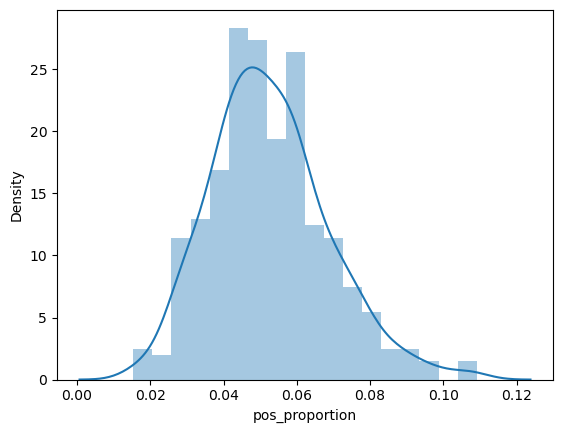

In [34]:
sns_plot = sns.distplot(df_new['pos_proportion'])
fig = sns_plot.get_figure()

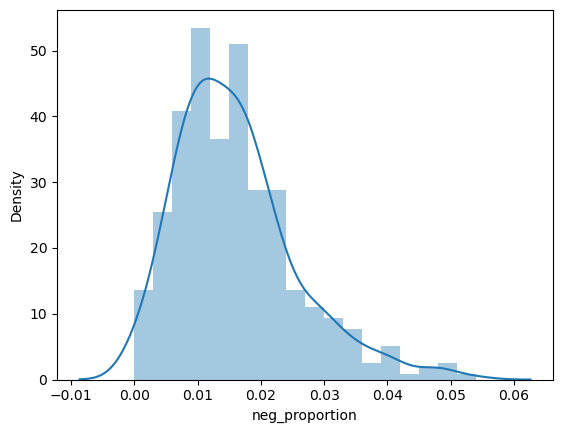

In [35]:
sns_plot = sns.distplot(df_new['neg_proportion'])
fig = sns_plot.get_figure()

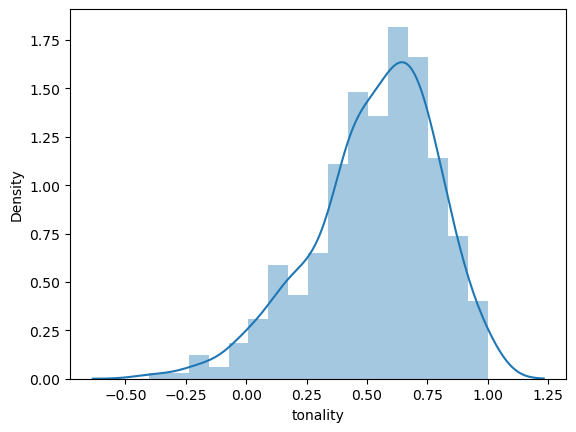

In [36]:
sns_plot = sns.distplot(df_new['tonality'])
fig = sns_plot.get_figure()

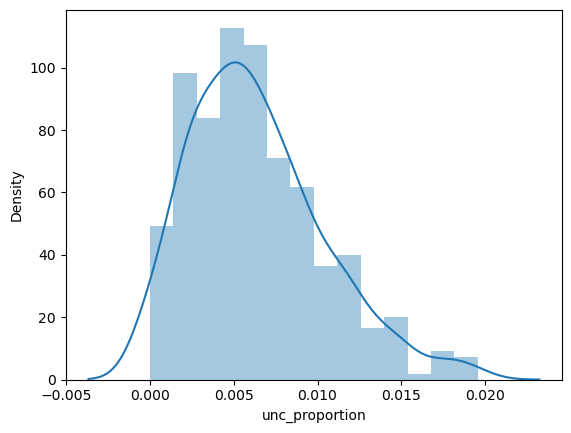

In [37]:
sns_plot = sns.distplot(df_new['unc_proportion'])
fig = sns_plot.get_figure()

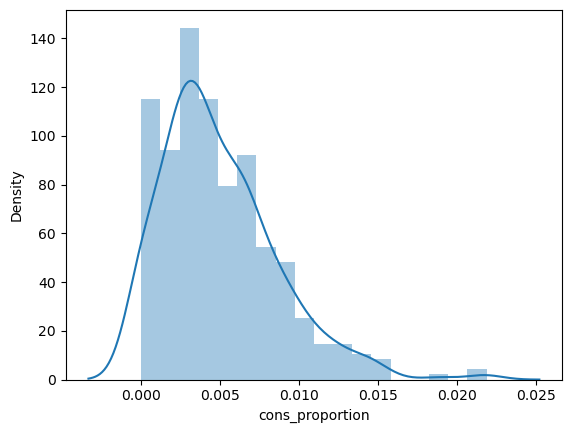

In [38]:
sns_plot = sns.distplot(df_new['cons_proportion'])
fig = sns_plot.get_figure()

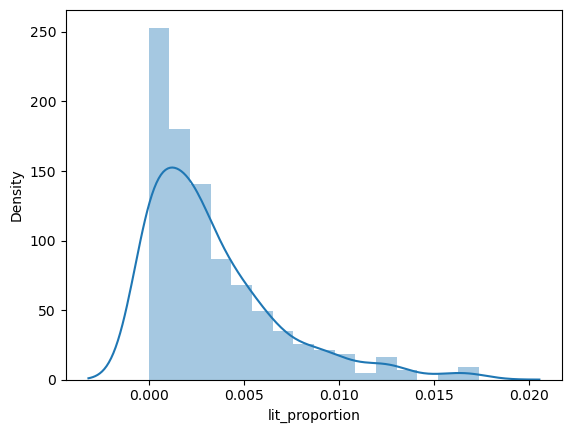

In [39]:
sns_plot = sns.distplot(df_new['lit_proportion'])
fig = sns_plot.get_figure()

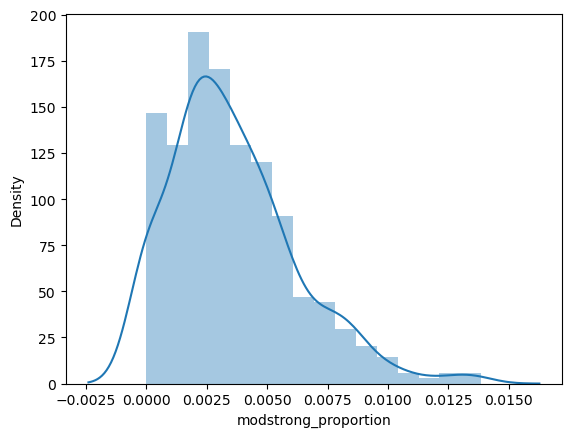

In [40]:
sns_plot = sns.distplot(df_new['modstrong_proportion'])
fig = sns_plot.get_figure()

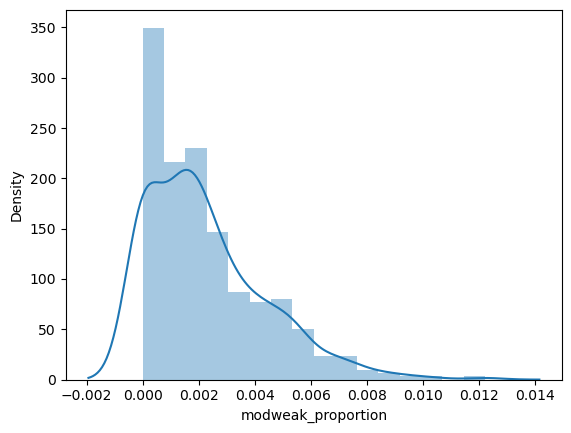

In [41]:
sns_plot = sns.distplot(df_new['modweak_proportion'])
fig = sns_plot.get_figure()

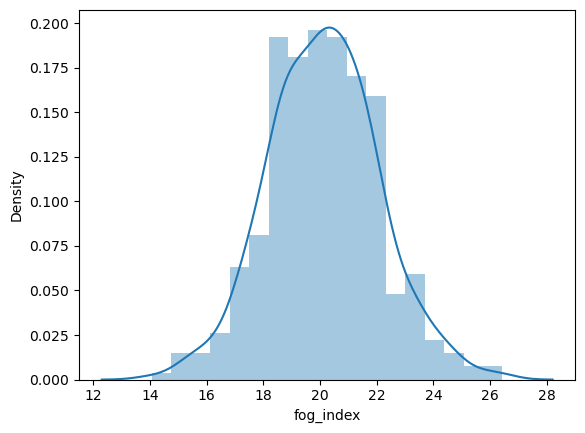

In [42]:
sns_plot = sns.distplot(df_new['fog_index'])
fig = sns_plot.get_figure()

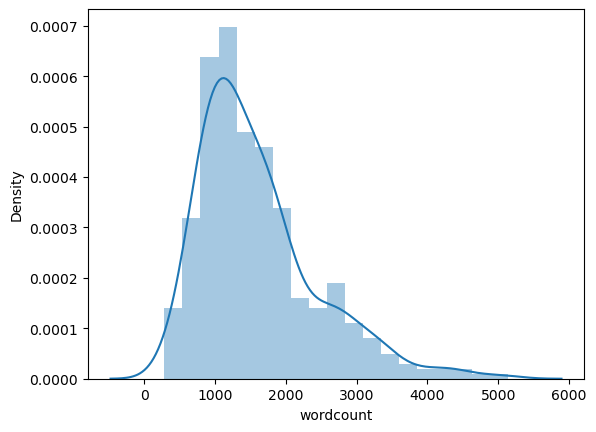

In [43]:
sns_plot = sns.distplot(df_new['wordcount'])
fig = sns_plot.get_figure()

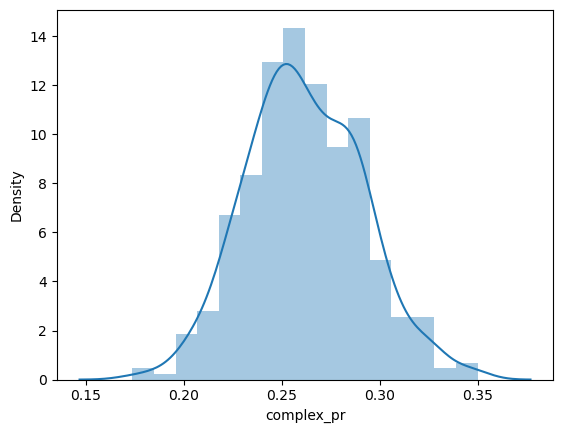

In [44]:
sns_plot = sns.distplot(df_new['complex_pr'])
fig = sns_plot.get_figure()

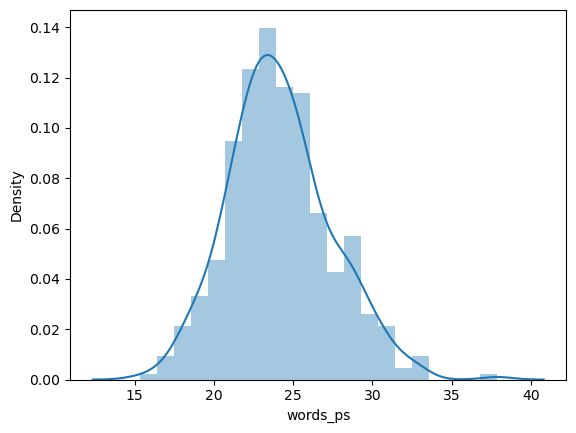

In [45]:
sns_plot = sns.distplot(df_new['words_ps'])
fig = sns_plot.get_figure()

In [36]:
corr = X.corr()
corr.style.background_gradient(cmap='Blues')
corr.style.background_gradient(cmap='Blues').to_excel('corr.xlsx')

In [47]:
# pos_proportion tonality
# neg_proportion tonality
# modweak_proportion unc_proportion
# lit_proportion fog_index

In [37]:
X.describe()

,pos_proportion,neg_proportion,tonality,unc_proportion,cons_proportion,lit_proportion,modstrong_proportion,modweak_proportion,fog_index,wordcount,complex_pr,words_ps
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,0.052540,0.016014,0.530042,0.006345,0.004983,0.003340,0.003590,0.002275,20.112495,1612.090674,0.261471,24.134155
std,0.016094,0.009597,0.255699,0.004057,0.003679,0.003448,0.002642,0.002133,1.955166,837.825856,0.029882,3.254983
min,0.015385,0.000000,-0.403509,0.000000,0.000000,0.000000,0.000000,0.000000,14.060467,286.000000,0.173913,15.316456
25%,0.041731,0.009466,0.400000,0.003199,0.002454,0.000914,0.001779,0.000697,18.766055,1018.000000,0.241519,22.012027
50%,0.050675,0.014698,0.569498,0.005672,0.004216,0.002417,0.003159,0.001813,20.089604,1398.500000,0.259441,23.799551
75%,0.060812,0.021093,0.709881,0.008628,0.006880,0.004899,0.004995,0.003425,21.379138,1970.750000,0.283012,26.031250
max,0.109091,0.053942,1.000000,0.019567,0.021886,0.017370,0.013871,0.012220,26.438648,5133.000000,0.349892,37.854545


In [48]:
def slope(xs, ys):
#    '''Вычисление наклона линии (углового коэффициента)'''
    return np.cov(xs, ys)[1][0] / np.var(xs)

def intercept(xs, ys): 
#     '''Вычисление точки пересечения (с осью Y)'''
   return np.mean(ys) - (np.mean(xs) * slope(xs, ys))

In [49]:
x = pd.read_csv('x_model1.csv')
X_ = x.drop(columns = ['Unnamed: 0', 'tonality', 'complex_pr', 'words_ps', 'neg_proportion',
                          'modweak_proportion', 'cons_proportion', 'lit_proportion'],axis = 1)

const_ = 0
counter = 0
for i in X_:
    counter += 1
    const_ += intercept(X_[i], y)
const = const_ / counter

In [50]:
X_.insert(0, "const", const)
X_

,const,pos_proportion,unc_proportion,modstrong_proportion,fog_index,wordcount
0,0.214561,0.037773,0.010903,0.001947,19.306048,4829.0
1,0.214561,0.092437,0.005602,0.005602,19.764655,673.0
2,0.214561,0.060215,0.004301,0.002151,21.064719,869.0
3,0.214561,0.082212,0.010463,0.005232,19.937673,2483.0
4,0.214561,0.029557,0.002463,0.004926,20.449675,758.0
...,...,...,...,...,...,...
388,0.214561,0.063892,0.003872,0.008712,18.682194,1928.0
389,0.214561,0.071960,0.007444,0.000000,21.666208,752.0
390,0.214561,0.069993,0.014892,0.008935,21.417283,2611.0
391,0.214561,0.043870,0.004499,0.005062,20.731535,3314.0


In [51]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as smd

results = smd.Logit(y, X_).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.545111
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:                  393
Model:                          Logit   Df Residuals:                      387
Method:                           MLE   Df Model:                            5
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                 0.02452
Time:                        21:03:06   Log-Likelihood:                -214.23
converged:                       True   LL-Null:                       -219.61
Covariance Type:            nonrobust   LLR p-value:                   0.05613
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -10.3973      6.045     -1.720      0.085     -22.245       1.450

### Масштабируем признаки

In [52]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class CustomScaler(TransformerMixin): # создаем собственный класс, опираясь на уже существующий метод
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [53]:
sc = CustomScaler(X_.columns.to_list())
X_new = sc.fit_transform(X_)

X_new

,const,pos_proportion,unc_proportion,modstrong_proportion,fog_index,wordcount
0,-5.551115e-17,-0.927497,1.127330,-0.617635,-0.423183,3.869187
1,-5.551115e-17,2.451370,-0.187992,0.765208,-0.187503,-1.110133
2,-5.551115e-17,0.459697,-0.510835,-0.540647,0.480607,-0.875305
3,-5.551115e-17,1.819369,1.018146,0.625020,-0.098588,1.058435
4,-5.551115e-17,-1.435333,-0.966882,0.509412,0.164532,-1.008294
...,...,...,...,...,...,...
388,-5.551115e-17,0.686947,-0.617243,1.941883,-0.743784,0.393487
389,-5.551115e-17,1.185684,0.269024,-1.354243,0.789714,-1.015483
390,-5.551115e-17,1.064055,2.116977,2.026147,0.661791,1.211792
391,-5.551115e-17,-0.550639,-0.461618,0.560773,0.309382,2.054059


In [54]:
X_new.to_csv('model1_X.csv')

### Модели

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, stratify = y)

#### Логистическая регрессия

In [56]:
lr = LogisticRegression(random_state=42) 

params = {'solver': ['sag', 'saga', 'lbfgs'],
         'C': np.arange(1,100,1),
         'penalty': ['l1','l2','elasticnet']} 
grid_lr = GridSearchCV(lr, params, cv = 3, scoring = 'recall') 

grid_lr.fit(X_new, y)

print('best score:', grid_lr.best_score_)
print('best params:', grid_lr.best_params_)

best score: 0.0
best params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [57]:
lr = LogisticRegression(C = 1, solver = 'sag', penalty = 'l2')
lr.fit(X_train, y_train)

lr_ypred_train = lr.predict(X_train)
lr_ypred_test = lr.predict(X_test)
lr_ypred = lr.predict(X_new)

0.6057149941114486

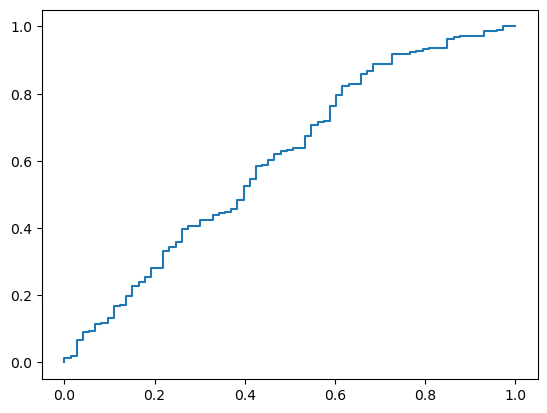

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, lr.predict_proba(X_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.5822222222222222

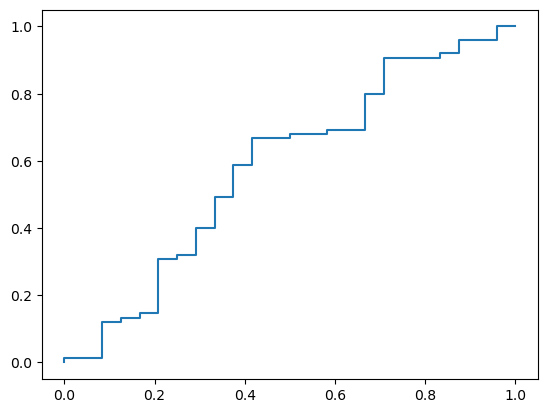

In [59]:
tpr, fpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [60]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [61]:
accuracy_score(y_train,lr_ypred_train), accuracy_score(y_test,lr_ypred_test)

(0.7517006802721088, 0.7575757575757576)

In [62]:
f1_score(y_train,lr_ypred_train), f1_score(y_test,lr_ypred_test)

(0.0, 0.0)

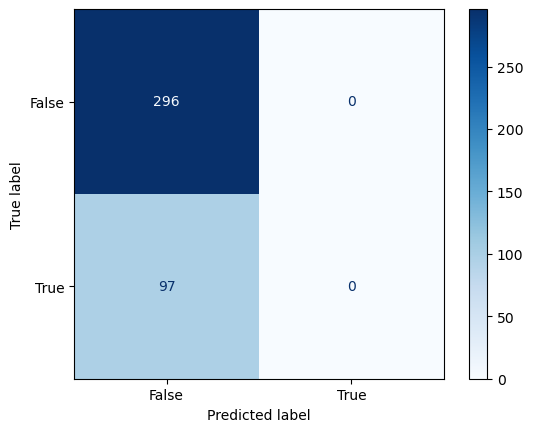

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, lr_ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

#### Дерево решений

In [64]:
tree1 = DecisionTreeClassifier(random_state=42)
tree1.fit(X_train, y_train)

pred_tree1 = tree1.predict(X_test)
print(f1_score(y_test, pred_tree1, average=None))

[0.77852349 0.32653061]


In [65]:
params = {'max_features' : ['log2' , 'sqrt'],
          'max_depth': np.arange(1,10),
          'criterion': ['gini', 'entropy', 'log_loss']}

tree_cv = GridSearchCV(tree1, params, cv = 3, scoring = 'recall')
tree_cv.fit(X_new, y)

print('Best params:', tree_cv.best_params_)
print('Best Score:', tree_cv.best_score_)

Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2'}
Best Score: 0.22632575757575757


In [66]:
tree = DecisionTreeClassifier(random_state = 42, criterion = 'gini', 
                              max_depth = 8, max_features = 'log2') 

tree.fit(X_train, y_train)

tree_ypred_train = tree.predict(X_train)
tree_ypred_test = tree.predict(X_test)
tree_ypred = tree.predict(X_new)

0.9363106675757764

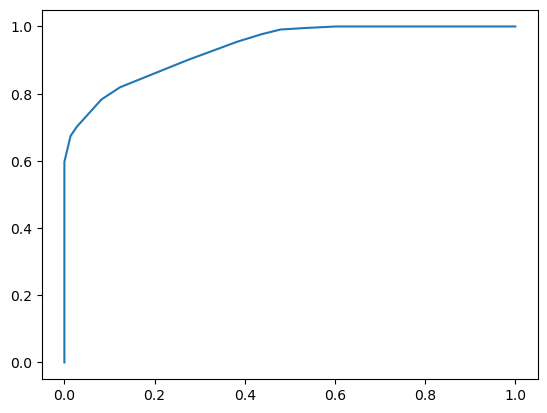

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, tree.predict_proba(X_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.5819444444444445

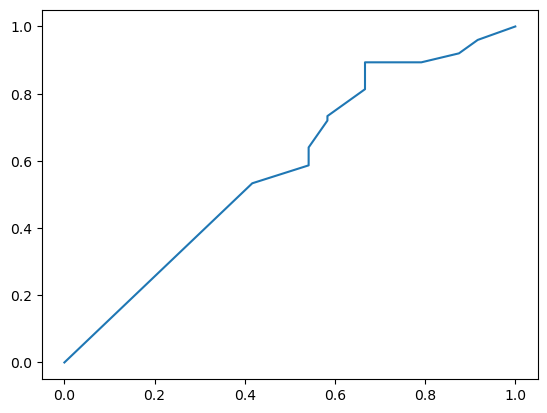

In [68]:
tpr, fpr, _ = roc_curve(y_test, tree.predict_proba(X_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [69]:
accuracy_score(y_train,tree_ypred_train), accuracy_score(y_test,tree_ypred_test)

(0.8741496598639455, 0.7272727272727273)

In [70]:
f1_score(y_train,tree_ypred_train), f1_score(y_test,tree_ypred_test)

(0.6725663716814159, 0.18181818181818182)

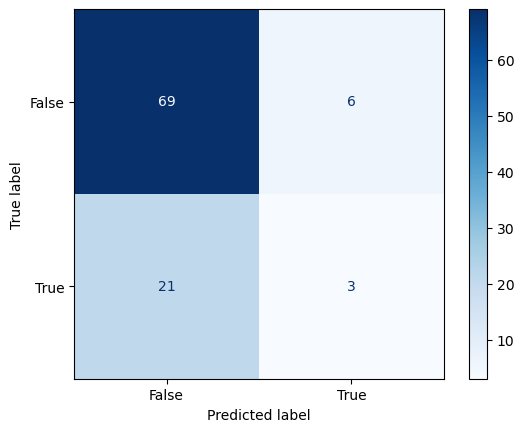

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, tree_ypred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

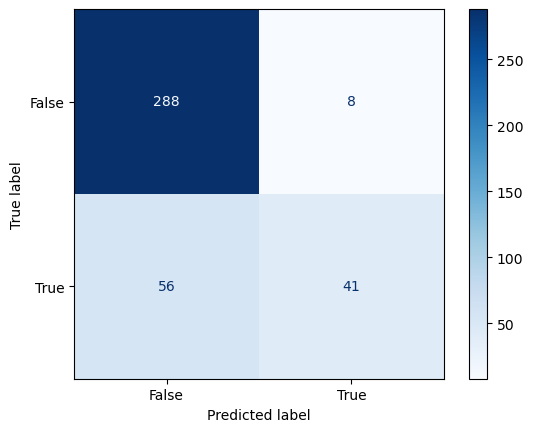

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, tree_ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

### SGD

In [73]:
sgd1 = SGDClassifier(random_state = 42)
sgd1.fit(X_train, y_train)

pred_sgd1 = sgd1.predict(X_test)
print(f1_score(y_test, pred_sgd1, average=None))

[0.81481481 0.16666667]


In [74]:
params = {'loss' : ['modified_huber', 'log_loss'],
          'penalty': ['l2', 'l1', 'elasticnet']}

sgd_cv = GridSearchCV(sgd1, params, cv = 3, scoring = 'recall')
sgd_cv.fit(X_new, y)

print('Best params:', sgd_cv.best_params_)
print('Best Score:', sgd_cv.best_score_)

Best params: {'loss': 'modified_huber', 'penalty': 'elasticnet'}
Best Score: 0.3178661616161616


In [75]:
sgd = SGDClassifier(random_state = 42, loss = 'modified_huber', penalty = 'l1') 

sgd.fit(X_train, y_train)

sgd_ypred_train = sgd.predict(X_train)
sgd_ypred_test = sgd.predict(X_test)
sgd_ypred = sgd.predict(X_new)

0.575993305646811

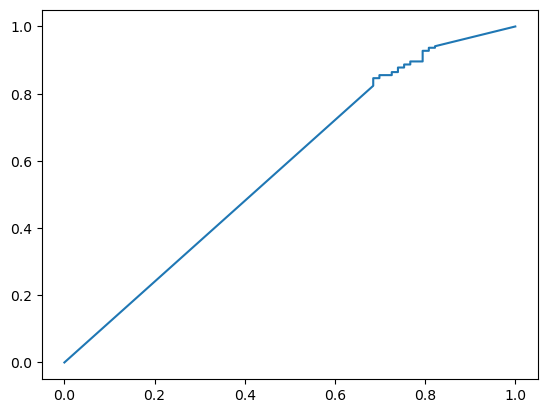

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, sgd.predict_proba(X_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.5261111111111112

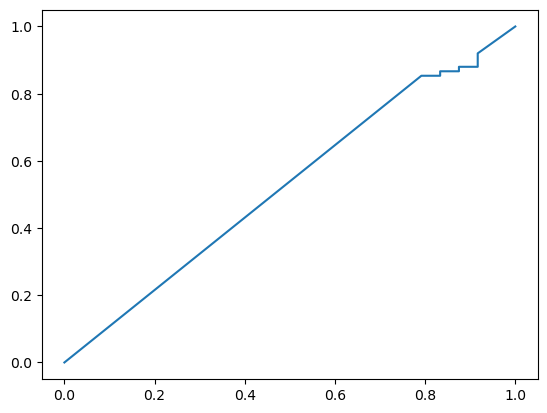

In [77]:
tpr, fpr, _ = roc_curve(y_test, sgd.predict_proba(X_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [78]:
accuracy_score(y_train,sgd_ypred_train), accuracy_score(y_test,sgd_ypred_test)

(0.7278911564625851, 0.6868686868686869)

In [79]:
f1_score(y_train,sgd_ypred_train), f1_score(y_test,sgd_ypred_test)

(0.2982456140350877, 0.16216216216216217)

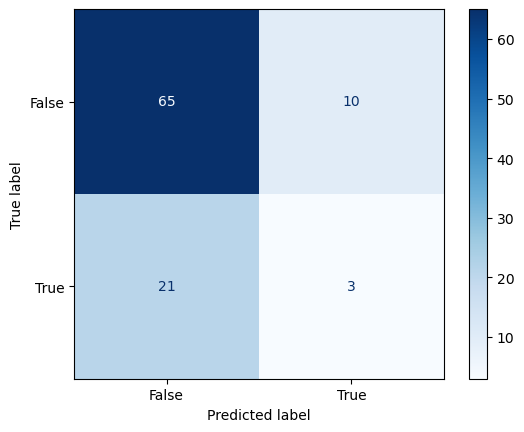

In [80]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, sgd_ypred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

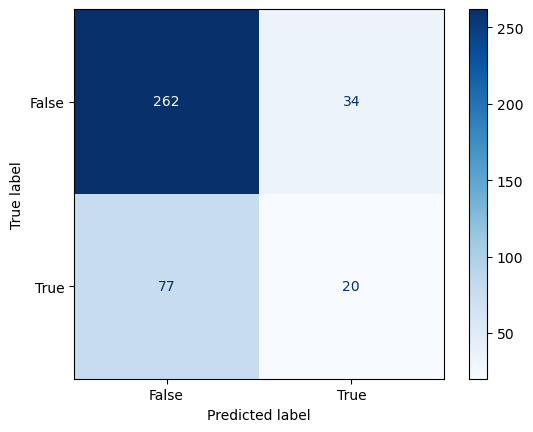

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, sgd_ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

### SVM

In [82]:
svm1 = SVC(random_state = 42)

svm1.fit(X_train, y_train)

pred_svm1 = svm1.predict(X_test)
print(f1_score(y_test, pred_svm1, average=None))

[0.86206897 0.        ]


In [83]:
params = {'C': np.arange(1,80,1),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm_cv = GridSearchCV(svm1, params, cv = 3, scoring = 'recall')
svm_cv.fit(X_new, y)

print('Best params:', svm_cv.best_params_)
print('Best Score:', svm_cv.best_score_)

Best params: {'C': 47, 'kernel': 'sigmoid'}
Best Score: 0.3096590909090909


In [84]:
svm = SVC(random_state = 42, C = 10, kernel = 'sigmoid', probability = True) 

svm.fit(X_train, y_train)

svm_ypred_train = svm.predict(X_train)
svm_ypred_test = svm.predict(X_test)
svm_ypred = svm.predict(X_new)

0.5576148267526189

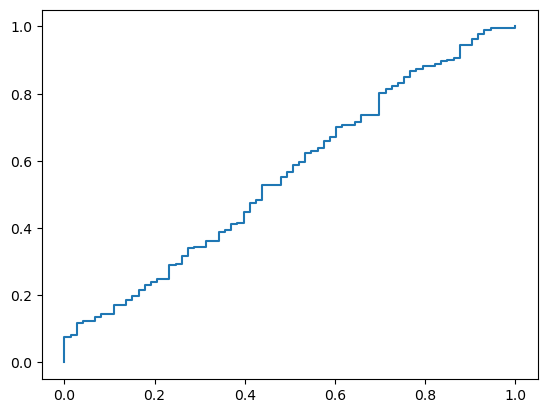

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, svm.predict_proba(X_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.4277777777777778

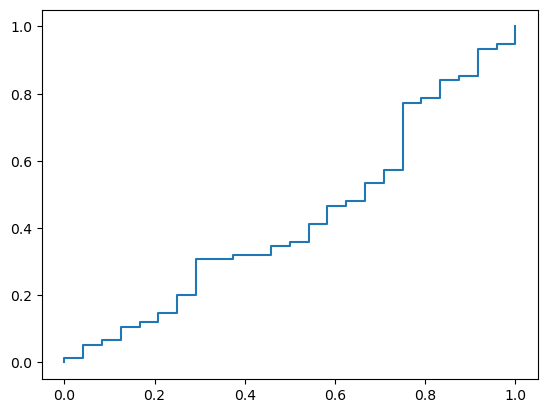

In [86]:
tpr, fpr, _ = roc_curve(y_test, svm.predict_proba(X_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [87]:
accuracy_score(y_train,svm_ypred_train), accuracy_score(y_test,svm_ypred_test)

(0.6190476190476191, 0.6666666666666666)

In [88]:
f1_score(y_train,svm_ypred_train), f1_score(y_test,svm_ypred_test)

(0.2222222222222222, 0.26666666666666666)

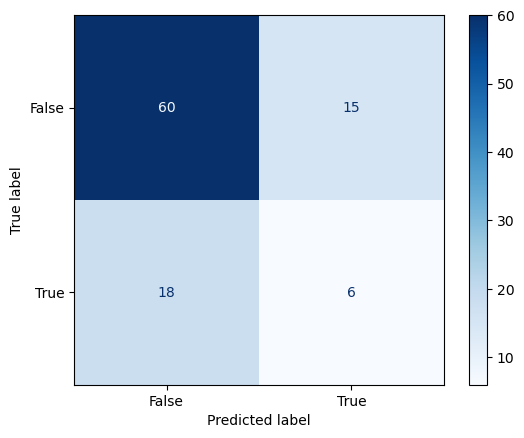

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, svm_ypred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

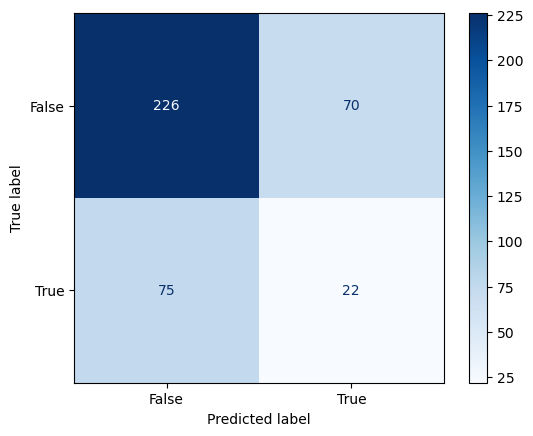

In [90]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, svm_ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

### Gradient boosting

In [91]:
boost1 = GradientBoostingClassifier(random_state = 42)

boost1.fit(X_train, y_train)

pred_boost1 = boost1.predict(X_test)
print(f1_score(y_test, pred_boost1, average=None))

[0.85207101 0.13793103]


In [92]:
params = {'n_estimators': np.arange(0,80,1)}

boost_cv = GridSearchCV(boost1, params, cv = 3, scoring = 'recall')
boost_cv.fit(X_new, y)

print('Best params:', boost_cv.best_params_)
print('Best Score:', boost_cv.best_score_)

Best params: {'n_estimators': 64}
Best Score: 0.1534090909090909


In [93]:
params = {'max_features' : ['log2', 'sqrt'],
          'criterion': ['friedman_mse', 'squared_error', 'mse']}

boost01 = GradientBoostingClassifier(n_estimators = 52)

boost1_cv = GridSearchCV(boost01, params, cv = 3, scoring = 'recall')
boost1_cv.fit(X_new, y)

print('Best params:', boost1_cv.best_params_)
print('Best Score:', boost1_cv.best_score_)

Best params: {'criterion': 'friedman_mse', 'max_features': 'log2'}
Best Score: 0.13352272727272727


In [94]:
boost = GradientBoostingClassifier(n_estimators = 52, criterion = 'squared_error', max_features = 'log2')

boost.fit(X_train, y_train)

boost_ypred_train = boost.predict(X_train)
boost_ypred_test = boost.predict(X_test)
boost_ypred = boost.predict(X_new)

0.9727267092295295

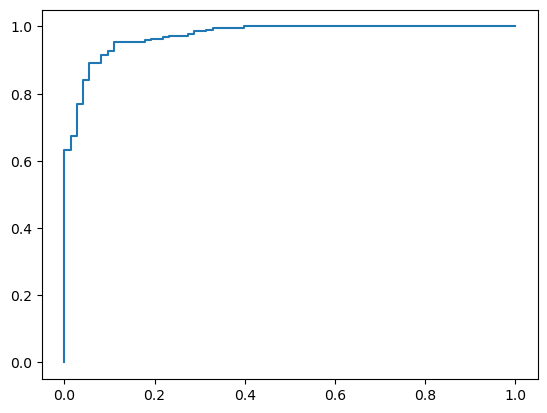

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
tpr, fpr, _ = roc_curve(y_train, boost.predict_proba(X_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.5033333333333334

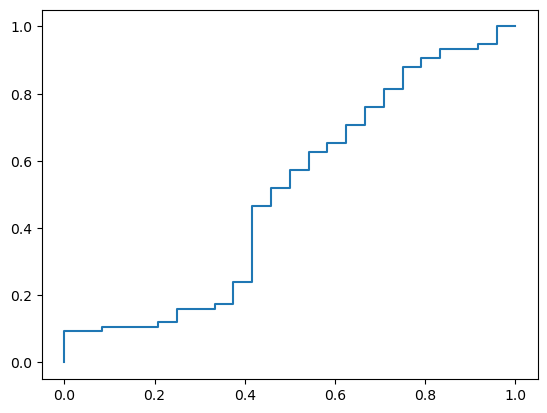

In [96]:
tpr, fpr, _ = roc_curve(y_test, boost.predict_proba(X_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [97]:
accuracy_score(y_train,boost_ypred_train), accuracy_score(y_test,boost_ypred_test)

(0.8843537414965986, 0.7272727272727273)

In [98]:
f1_score(y_train,boost_ypred_train), f1_score(y_test,boost_ypred_test)

(0.6964285714285715, 0.06896551724137931)

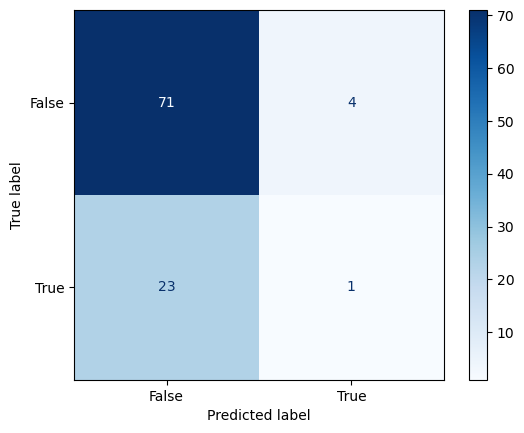

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, boost_ypred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

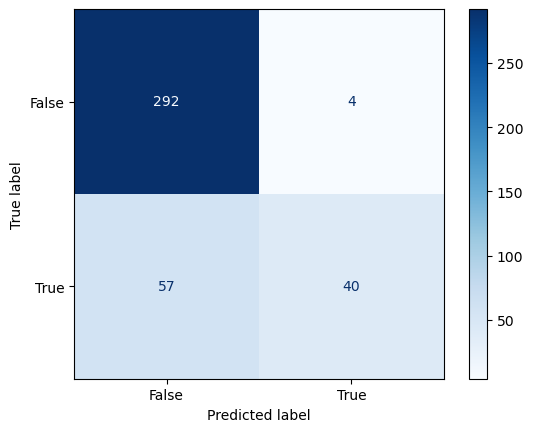

In [100]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, boost_ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

### Выбор оптимальной модели

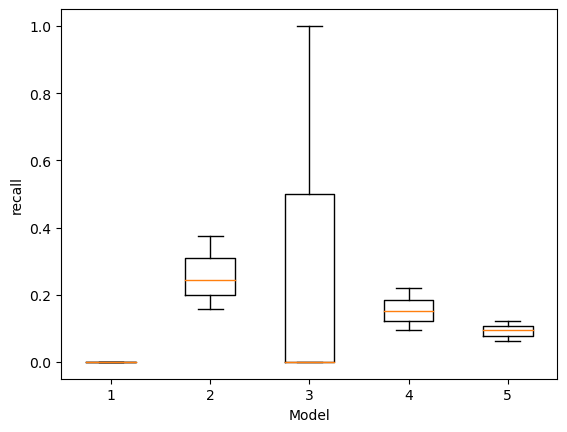

In [101]:
from sklearn.model_selection import cross_validate

#1
cv_log_best = cross_validate(lr, X, y, cv = 3, scoring = 'recall')

#2
cv_tree_best = cross_validate(tree, X, y, cv = 3, scoring = 'recall')

#3
cv_sgd_best = cross_validate(sgd, X, y, cv = 3, scoring = 'recall')

#4
cv_svm_best = cross_validate(svm, X, y, cv = 3, scoring = 'recall')

#5
cv_boost_best = cross_validate(boost, X, y, cv = 3, scoring = 'recall')

data = [cv_log_best['test_score'], cv_tree_best['test_score'], cv_sgd_best['test_score'], 
        cv_svm_best['test_score'], cv_boost_best['test_score']]
plt.boxplot(data)
plt.xlabel("Model")
plt.ylabel("recall")
plt.show()

In [102]:
precisions, recalls, f1scores, accuracys, rocaucs = [], [], [], [], []

def data(score):
    cv_log_best = cross_validate(lr, X, y, cv = 3, scoring = score)
    cv_tree_best = cross_validate(tree, X, y, cv = 3, scoring = score)
    cv_sgd_best = cross_validate(sgd, X, y, cv = 3, scoring = score)
    cv_svm_best = cross_validate(svm, X, y, cv = 3, scoring = score)
    cv_boost_best = cross_validate(boost, X, y, cv = 3, scoring = score)
    return [cv_log_best['test_score'], cv_tree_best['test_score'], cv_sgd_best['test_score'], 
            cv_svm_best['test_score'], cv_boost_best['test_score']]

def average(data, frame):
    for i in data:
        average = 0
        for j in i:
            average += j
        average = average / 3
        frame.append(average)
    return frame

average(data('precision'), precisions)
average(data('recall'), recalls)
average(data('roc_auc'), rocaucs)
average(data('f1'), f1scores)
average(data('accuracy'), accuracys)

[0.7531806615776082,
 0.6488549618320612,
 0.5826972010178118,
 0.6005089058524172,
 0.732824427480916]

In [103]:
model = ['lr', 'tree', 'sgd', 'svm', 'boost']
metrics_cv = pd.DataFrame({'f1_score': f1scores, 'precision': precisions, 'recall': recalls, 'ROC AUC': rocaucs, 
                        'accuracy': accuracys}, index=model)
metrics_cv

,f1_score,precision,recall,ROC AUC,accuracy
lr,0.000000,0.000000,0.000000,0.542665,0.753181
tree,0.262789,0.269125,0.257891,0.505276,0.648855
sgd,0.130879,0.081425,0.333333,0.526253,0.582697
svm,0.160572,0.167026,0.154672,0.486976,0.600509
boost,0.123077,0.268687,0.092803,0.567147,0.732824


In [104]:
print(metrics_cv.max())

f1_score     0.262789
precision    0.269125
recall       0.333333
ROC AUC      0.567147
accuracy     0.753181
dtype: float64
